Reading csv files with PySpark

In [1]:
import pandas as pd 

In [2]:
# read_file = pd.read_excel ("Online Retail.xlsx")
# read_file.to_csv("OnlineRetail.csv", index = None, header=True)

In [2]:
df = pd.DataFrame(pd.read_csv("OnlineRetail.csv"))
df.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047.0,United Kingdom


Phân tích dữ liệu cơ bản

In [4]:
# Init SparkSession
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Pyspark Tutorial").config("spark.memory.offHeap.enabled","true").config("spark.memory.offHeap.size","10g").getOrCreate()


In [5]:
#Read data fame
df = spark.read.csv("OnlineRetail.csv", header=True, escape="\"")

In [6]:
df.show(5)

+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|2010-12-01 08:26:00|     2.55|   17850.0|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingdom|
|   536365|   84406B|CREAM CUPID HEART...|       8|2010-12-01 08:26:00|     2.75|   17850.0|United Kingdom|
|   536365|   84029G|KNITTED UNION FLA...|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingdom|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingdom|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
only showing top 5 rows



In [7]:
# Đếm xem có bao nhiêu dòng dữ liệu
df.count()

541909

In [8]:
# Có bao nhiêu khách hàng
df.select('CustomerID').distinct().count()

4373

In [9]:
# Quốc gia nào có số lượng khách hàng thế nào
#agg(): (aggregate values) tính toán các giá trị tổng hợp
# alisa(): đặt tên 1 cột
from pyspark.sql.functions import countDistinct, desc
df.groupBy('Country').agg(countDistinct('CustomerID').alias('country_count')).orderBy(desc('country_count')).show()


+---------------+-------------+
|        Country|country_count|
+---------------+-------------+
| United Kingdom|         3950|
|        Germany|           95|
|         France|           87|
|          Spain|           31|
|        Belgium|           25|
|    Switzerland|           21|
|       Portugal|           19|
|          Italy|           15|
|        Finland|           12|
|        Austria|           11|
|         Norway|           10|
|        Denmark|            9|
|Channel Islands|            9|
|      Australia|            9|
|    Netherlands|            9|
|         Sweden|            8|
|         Cyprus|            8|
|          Japan|            8|
|         Poland|            6|
|         Greece|            4|
+---------------+-------------+
only showing top 20 rows



In [10]:
# Định dạng lại trường dữ liệu ngày tháng thành timestamp để có thể sort, tìm min hoặc max
from pyspark.sql.functions import to_timestamp
spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")
df = df.withColumn('date',to_timestamp("InvoiceDate", 'yy-MM-dd HH:mm:ss'))

In [11]:
# Ngày có đơn hàng gần đây nhất
from pyspark.sql.functions import max
df.select(max("date")).show()

+-------------------+
|          max(date)|
+-------------------+
|2011-12-09 12:50:00|
+-------------------+



In [12]:
# Ngày đầu tiên có đơn hàng
from pyspark.sql.functions import min
df.select(min("date")).show()

+-------------------+
|          min(date)|
+-------------------+
|2010-12-01 08:26:00|
+-------------------+



Tiền xử lý dữ liệu

Recency: Khách hàng mua hàng gần đây, được xem là quan trọng hơn so với khách hàng lâu ko mua hàng

In [13]:
from pyspark.sql.functions import lit,col
df = df.withColumn("from_date", lit("2010-12-01 08:26:00"))

In [14]:
df = df.withColumn('from_date',to_timestamp("from_date", 'yy-MM-dd HH:mm'))
df2 = df.withColumn('from_date',to_timestamp(col('from_date'))).withColumn('recency',col("date").cast("long") - col('from_date').cast("long"))

In [15]:
df2 = df2.join(df2.groupBy('CustomerID').agg(max('recency').alias('recency')),on='recency',how='leftsemi')


In [16]:
import pyspark.sql.functions as f
df_freq = df2.groupBy('CustomerID').agg(f.count('InvoiceNo').alias('frequency'))


In [17]:
df3 = df2.join(df_freq,on='CustomerID',how='inner')

In [21]:
m_val = df3.withColumn('TotalAmount',col("Quantity") * col("UnitPrice"))

In [23]:
m_val = m_val.groupBy('CustomerID').agg(f.sum('TotalAmount').alias('monetary_value'))

In [25]:
m_val.show()

+----------+-------------------+
|CustomerID|     monetary_value|
+----------+-------------------+
|   15070.0|              106.2|
|   16718.0|  623.7500000000002|
|   17850.0|             126.38|
|   16499.0|              -2.95|
|   15204.0| 316.58000000000004|
|   16270.0| 1141.2399999999996|
|   12386.0|              143.0|
|   18119.0| 181.11999999999998|
|   13922.0| 172.24999999999997|
|   13958.0|            -102.45|
|   17307.0|-152.64000000000001|
|   17950.0|             208.95|
|   13295.0|              201.2|
|   17925.0|             244.08|
|   16893.0| 145.93000000000004|
|   13369.0|             -44.53|
|   14119.0|              -19.9|
|   16583.0| 233.45000000000002|
|   14237.0| 161.00000000000003|
|   16665.0|              135.4|
+----------+-------------------+
only showing top 20 rows



In [24]:
final_df = m_val.join(df3,on='CustomerID',how='inner')

In [26]:
final_df.show()

+----------+-----------------+-------+---------+---------+--------------------+--------+-------------------+---------+--------------+-------------------+-------------------+---------+
|CustomerID|   monetary_value|recency|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|       Country|               date|          from_date|frequency|
+----------+-----------------+-------+---------+---------+--------------------+--------+-------------------+---------+--------------+-------------------+-------------------+---------+
|   15070.0|            106.2|  97020|   536636|    22086|PAPER CHAIN KIT 5...|      36|2010-12-02 11:23:00|     2.95|United Kingdom|2010-12-02 11:23:00|2010-12-01 08:26:00|        1|
|   16718.0|623.7500000000002| 362220|   537153|    84836|ZINC METAL HEART ...|      12|2010-12-05 13:03:00|     1.25|United Kingdom|2010-12-05 13:03:00|2010-12-01 08:26:00|       45|
|   16718.0|623.7500000000002| 362220|   537153|    21014|SWISS CHALET TREE...| 

In [27]:
final_df = final_df.select(['recency','frequency','monetary_value','CustomerID']).distinct()

In [28]:
final_df.show()

+-------+---------+-------------------+----------+
|recency|frequency|     monetary_value|CustomerID|
+-------+---------+-------------------+----------+
|  97020|        1|              106.2|   15070.0|
| 362220|       45|  623.7500000000002|   16718.0|
|  91080|       32|             126.38|   17850.0|
|1148040|        1|              -2.95|   16499.0|
|1401780|        9| 316.58000000000004|   15204.0|
|1749600|       54| 1141.2399999999996|   16270.0|
|3125460|        2|              143.0|   12386.0|
| 531180|       30| 181.11999999999998|   18119.0|
|1908720|        7| 172.24999999999997|   13922.0|
| 117420|        5|            -102.45|   13958.0|
| 716280|        1|-152.64000000000001|   17307.0|
| 716280|       33|             208.95|   17950.0|
|1220100|       10|              201.2|   13295.0|
|  92640|        1|             244.08|   17925.0|
| 618000|       45| 145.93000000000004|   16893.0|
|1661760|        5|             -44.53|   13369.0|
|1661520|        1|            

In [29]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler

assemble=VectorAssembler(inputCols=[
    'recency','frequency','monetary_value'
], outputCol='features')

assembled_data=assemble.transform(final_df)

scale=StandardScaler(inputCol='features',outputCol='standardized')
data_scale=scale.fit(assembled_data)
data_scale_output=data_scale.transform(assembled_data)

In [30]:
data_scale_output.select('standardized').show(2, truncate=False)

+---------------------------------------------------------------+
|standardized                                                   |
+---------------------------------------------------------------+
|[0.011123700559287606,0.025819728443703036,0.03799110868989267]|
|[0.04152985793223209,1.1618877799666367,0.22313516050207685]   |
+---------------------------------------------------------------+
only showing top 2 rows



In [31]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import numpy as np

cost = np.zeros(10)
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='standardized',metricName='silhouette', distanceMeasure='squaredEuclidean')

for i in range(2,10):
    KMeans_algo=KMeans(featuresCol='standardized', k=i)
    KMeans_fit=KMeans_algo.fit(data_scale_output)
    output=KMeans_fit.transform(data_scale_output)
    cost[i] = KMeans_fit.summary.trainingCost

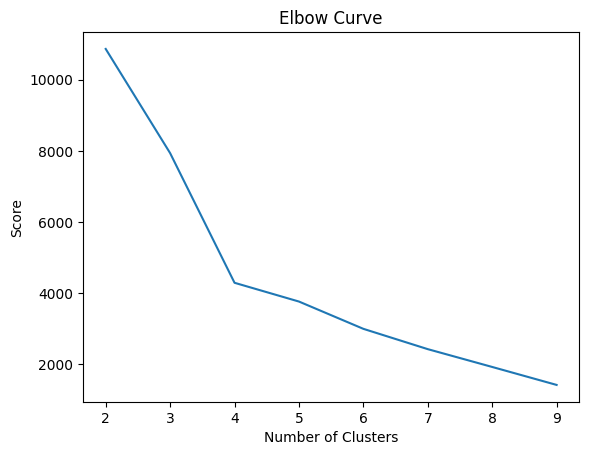

In [32]:
import pandas as pd
import pylab as pl
df_cost = pd.DataFrame(cost[2:])
df_cost.columns = ["cost"]
new_col = range(2,10)
df_cost.insert(0, 'cluster', new_col)
pl.plot(df_cost.cluster, df_cost.cost)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()

In [37]:
kmeans_algo=KMeans(featuresCol='standardized', k=4)
kmeans_fit=kmeans_algo.fit(data_scale_output)

In [38]:
preds=kmeans_fit.transform(data_scale_output)
preds.show(5)

+-------+---------+------------------+----------+--------------------+--------------------+----------+
|recency|frequency|    monetary_value|CustomerID|            features|        standardized|prediction|
+-------+---------+------------------+----------+--------------------+--------------------+----------+
|  97020|        1|             106.2|   15070.0| [97020.0,1.0,106.2]|[0.01112370055928...|         1|
| 362220|       45| 623.7500000000002|   16718.0|[362220.0,45.0,62...|[0.04152985793223...|         1|
|  91080|       32|            126.38|   17850.0|[91080.0,32.0,126...|[0.01044265766790...|         1|
|1148040|        1|             -2.95|   16499.0|[1148040.0,1.0,-2...|[0.13162701700767...|         1|
|1401780|        9|316.58000000000004|   15204.0|[1401780.0,9.0,31...|[0.16071924314572...|         1|
+-------+---------+------------------+----------+--------------------+--------------------+----------+
only showing top 5 rows



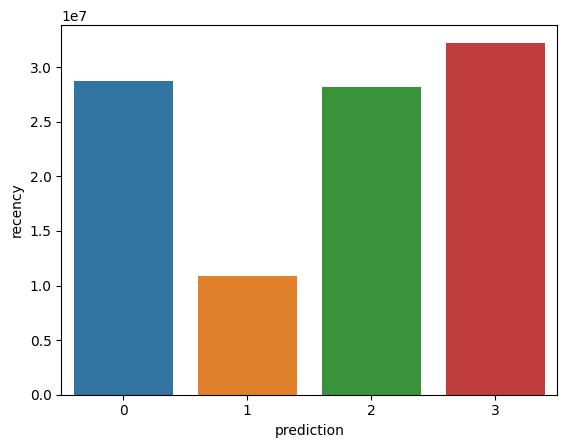

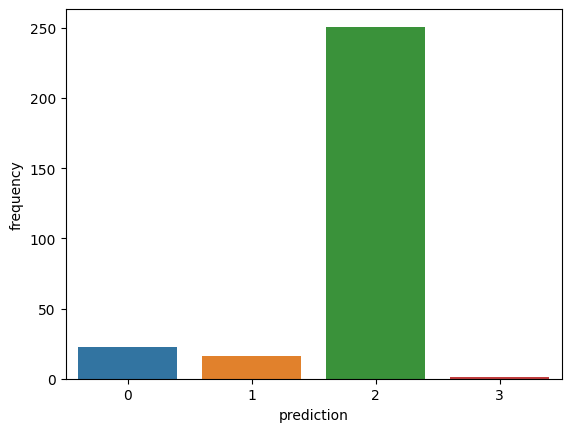

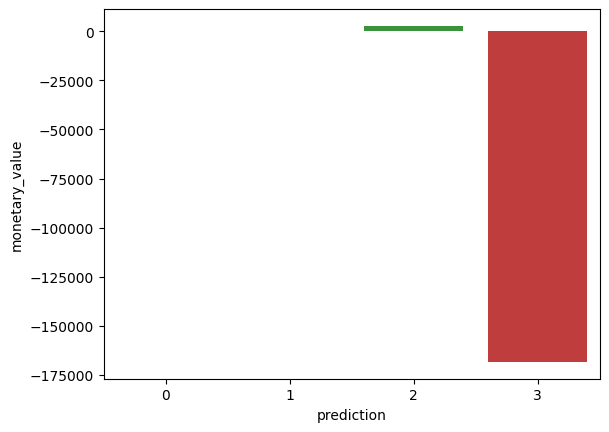

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

df_viz = preds.select('recency','frequency','monetary_value','prediction')
df_viz = df_viz.toPandas()
avg_df = df_viz.groupby(['prediction'], as_index=False).mean()

list1 = ['recency','frequency','monetary_value']

for i in list1:
    sns.barplot(x='prediction',y=str(i),data=avg_df)
    plt.show()

In [36]:
df_filter = df.select("*").filter(~col("InvoiceNo").startswith("C"))
# check xem số lượng dữ liệu còn bao nhiêu
df_filter.count()   # 532621
df_filter.select('CustomerID').distinct().count()  # 4340

4340